In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from pytorch_lightning import LightningModule, Trainer
from torch.utils.data import DataLoader, Dataset, Subset, random_split

import matplotlib.pyplot as plt
from pacmap import PaCMAP
import numpy as np
import pickle

In [18]:
PACMAP_SIZE = 10000 # Number of samples to use for PaCMAP
NUM_TARGETS = 1 # Number of resource features (y)
TRAIN_SPLIT = 0.8
BATCH_SIZE=1024
EPOCHS=1
FILE="data/libxml2_byteArrays.pkl"

In [3]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers, num_outputs):
        super(TransformerModel, self).__init__()
        self.embed = nn.Embedding(input_dim, input_dim)
        transformer_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_dim, num_outputs)

    def pooling(self, x):
        x = self.embed(x)  # Embedding input
        x = x.permute(1, 0, 2)  # Reshape for transformer
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)  # Pooling
        return x
        
    def forward(self, x):
        x = self.pooling(x)
        x = self.fc(x)
        return x

class ByteSequenceModel(LightningModule):
    def __init__(self):
        super(ByteSequenceModel, self).__init__()
        self.model = TransformerModel(input_dim=256, num_heads=8, num_layers=4, num_outputs=1)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [4]:
with open(FILE, 'rb') as file:
    byte_sequences, labels = pickle.load(file)

In [5]:
int_sequences = [[int(b) for b in byte_seq]  + [0] * (150 - len(byte_seq)) for byte_seq in byte_sequences]

In [6]:
int_sequences_tensor = torch.LongTensor(int_sequences)
labels_tensor = torch.FloatTensor(labels)

In [7]:
class ByteSequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [8]:
dataset = ByteSequenceDataset(int_sequences_tensor, labels_tensor)


In [9]:
# Splitting the dataset
train_size = int(TRAIN_SPLIT * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [10]:
class ByteSequenceDataModule(LightningModule):
    def __init__(self, train_dataset, val_dataset, batch_size=64):
        super().__init__()
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)


In [11]:
data_module = ByteSequenceDataModule(train_dataset, val_dataset, batch_size=BATCH_SIZE)
model = ByteSequenceModel()

/home/g/miniconda3/envs/amira/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [12]:
trainer = Trainer(max_epochs=EPOCHS) 
trainer.fit(model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-01-15 23:00:14.137407: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 23:00:14.163517: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has al

Sanity Checking: |                                                                                | 0/? [00:00…

/home/g/miniconda3/envs/amira/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/tmp/ipykernel_3267920/2005202402.py:38: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1024, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_hat, y)
/home/g/miniconda3/envs/amira/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                                                                       | 0/? [00:00…

/tmp/ipykernel_3267920/2005202402.py:32: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1024, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_hat, y)
/tmp/ipykernel_3267920/2005202402.py:32: UserWarning: Using a target size (torch.Size([789])) that is different to the input size (torch.Size([789, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_hat, y)


Validation: |                                                                                     | 0/? [00:00…

/tmp/ipykernel_3267920/2005202402.py:38: UserWarning: Using a target size (torch.Size([710])) that is different to the input size (torch.Size([710, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_hat, y)
`Trainer.fit` stopped: `max_epochs=1` reached.


In [17]:
from torch.utils.data import Subset


In [ ]:
def get_embeddings(model, loader):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for batch in loader:
            x, _ = batch
            context = model.model.pooling(x)
            embeddings.append(context)
    return torch.cat(embeddings)

val_loader = DataLoader(Subset(val_dataset, range(0,PACMAP_SIZE)), batch_size=BATCH_SIZE)
embeddings = get_embeddings(model, val_loader)

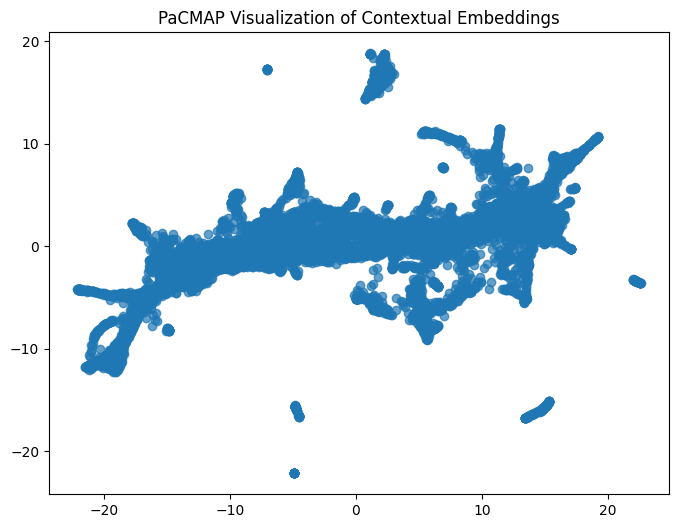

In [23]:
pacmap_instance = PaCMAP(n_components=2, n_neighbors=10, MN_ratio=0.5, FP_ratio=2.0)
reduced_embeddings = pacmap_instance.fit_transform(embeddings.cpu().numpy())

plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.7)
plt.title("PaCMAP Visualization of Contextual Embeddings")

plt.show()